In [25]:
from ds_loader import Dataset_Handler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch.nn.functional as F
import net
import numpy as np

In [26]:
'''
Initialise some things
'''
class Config():
    batch_size = 32
    epochs = 50
    learn_rate = 0.0001
    CLASSES = 5
    generate = False

mod_channel_dict = {
    0 : ("baseline.npy", 11),
    1 : ("modality1.npy", 6),
    2 : ("modality2.npy", 2),
    3 : ("modality3.npy", 1),
    4 : ("modality4.npy", 2)
}

dsh = Dataset_Handler(dataset_folder='sleep_lab_data', target_hertz=50)
# dsh = Dataset_Handler(dataset_folder='sleep_data_downsampling_AllSensorChannels_ lowfrequency_10HZ', target_hertz=10)


In [27]:
'''
Generate the data and store localy
'''
if Config.generate: dsh.generate_dataset()

In [28]:
'''
Choose mod for string of modality and for the corresponding input channels
'''
mod = 0

modality_string = mod_channel_dict[mod][0]
input_channels = mod_channel_dict[mod][1]

In [29]:
'''
Load Data(numpy array) from disk)
if you change modality change network input channels too
'''
train_dl, test_dl = dsh.get_dataloader(hertz=50,modality=modality_string, batch_size=Config.batch_size)
# train_dl, test_dl = dsh.get_dataloader(hertz=10,modality=modality_string, batch_size=Config.batch_size)

{'WK': 1223, 'N1': 325, 'N2': 1871, 'N3': 1462, 'REM': 1158}
{'WK': 1223, 'N1': 1300, 'N2': 1871, 'N3': 1462, 'REM': 1158}


In [30]:
# check for device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = net.SimpleNet(input_channels)
model.to(device)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=Config.learn_rate)
# define loss function
loss_function = nn.CrossEntropyLoss()

Config.batch_size = 258
# check if model is on correct device
next(model.parameters()).is_cuda


False

Yea we found better weights --> SAVE!!!
===> Epoch: 0 loss: 1.3984
Yea we found better weights --> SAVE!!!
===> Epoch: 1 loss: 1.0103
Yea we found better weights --> SAVE!!!
===> Epoch: 2 loss: 0.8021
Yea we found better weights --> SAVE!!!
===> Epoch: 3 loss: 0.7076
Yea we found better weights --> SAVE!!!
===> Epoch: 4 loss: 0.6567
Yea we found better weights --> SAVE!!!
===> Epoch: 5 loss: 0.5874
Yea we found better weights --> SAVE!!!
===> Epoch: 6 loss: 0.5446
Yea we found better weights --> SAVE!!!
===> Epoch: 7 loss: 0.4876
Yea we found better weights --> SAVE!!!
===> Epoch: 8 loss: 0.4345
Yea we found better weights --> SAVE!!!
===> Epoch: 9 loss: 0.3962
Yea we found better weights --> SAVE!!!
===> Epoch: 10 loss: 0.3632
Yea we found better weights --> SAVE!!!
===> Epoch: 11 loss: 0.3209
Yea we found better weights --> SAVE!!!
===> Epoch: 12 loss: 0.2807
Yea we found better weights --> SAVE!!!
===> Epoch: 13 loss: 0.2396
Yea we found better weights --> SAVE!!!
===> Epoch: 14 los

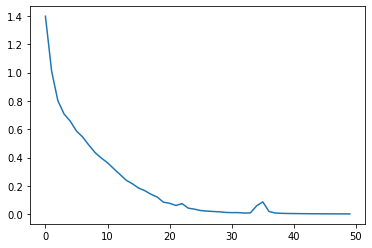

In [31]:
# Traning Process
loss_ls_train = []
best_epoch_loss = np.infty
model.train()

for epoch in range(Config.epochs):
    epoch_loss_sum = 0
    for data, labels in train_dl:

        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        data = data.permute(0, 2, 1)
        data = data.unsqueeze(2)

        prediction = model(data)

        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_sum += loss.data.item()
        epoch_loss_average = epoch_loss_sum/len(train_dl)
    loss_ls_train.append(epoch_loss_average)


    if epoch_loss_average < best_epoch_loss:

        best_epoch_loss = epoch_loss_average
        state = {'model_state': model.state_dict(),
                 'model_name': type(model).__name__,
                 'optimizer_state': optimizer.state_dict()}

        torch.save(state, "weights.pt")
        print("Yea we found better weights --> SAVE!!!")

    print('===> Epoch: {} loss: {:.4f}'.format(epoch, epoch_loss_average))

plt.plot(loss_ls_train)
plt.show()


In [32]:
model.load_state_dict(torch.load("weights.pt")['model_state'])
model.eval()

correct_pred = 0
num_pred = 0
map_sum = 0
f1_sum = 0
count = 0


for data, label in test_dl:
    data, label = data.to(device), label.to(device)

    data = data.permute(0, 2, 1)
    data = data.unsqueeze(2)
    softmax_v = F.softmax(model(data), dim=1)
    pred = torch.argmax(softmax_v, dim=1)

    num_pred += len(label)
    correct_pred = correct_pred + torch.eq(pred,label).sum().data.item()

    #tmp_map, _ = computeMeanAveragePrecision(label.detach().cpu().numpy(), softmax_v.detach().cpu().numpy())
    #map_sum += tmp_map
    count +=1

    f1_sum += f1_score(y_true=label.detach().cpu().numpy(), y_pred=pred.detach().cpu().numpy(), average='micro' )

print('Number of correct predictions: ' + str(correct_pred))
print('Number of Predictions: ' + str(num_pred))
print('Accuracy: ' + str(correct_pred/num_pred))
print('F1-score: ' + str(f1_sum/count))
# print('MAP: ' + str(map_sum/count))

Number of correct predictions: 1456
Number of Predictions: 2104
Accuracy: 0.6920152091254753
F1-score: 0.6916035353535354
